In [1]:
import pandas as pd
import numpy as np


import utilities.test_train_utils as ttu
import models.siamese_nn_utils as snu
import evaluation.faiss_umap_utils as fuu

from data_pipeline import data_preprocessing_utils as dpu

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm
import sys

from scipy.spatial import distance
import faiss, umap

/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h2>Dataset</h2>

- choose randomly 100 users for train set

- crate pairs with the ratio 5 negative to 1 positive

- check euclidean distance on the preprocess data data (before embedding) --> define margin



In [2]:
# read data
df_preprocessed = pd.read_csv('../tmp_processed_data/tmp_df_env_preprocessed_grouped_with_cat_min_max.csv')

# read original env data to create test/train/val set from session id
# we need the original data in the case if we want to create a dataset from the last sessions of each user
# for that we need the session_timestamp column which we don't have in the preprocessed data
df_env = pd.read_csv('../processed_data/df_env.csv')

#random state
rs = 42

# some preprocessing of the original data
w_df = df_env.copy()
w_df = dpu.IDTransformer('user_id').fit_transform(w_df)
w_df = dpu.IDTransformer('session_id').fit_transform(w_df)

/var/folders/p8/b11rskbj1zdf4sn__0fjfwdm0000gn/T/ipykernel_34922/646181006.py:7: DtypeWarning: Columns (11,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_env = pd.read_csv('../processed_data/df_env.csv')


In [3]:
# - choose randomly 100 users for train set
hundred_users = df_preprocessed['user_id'].sample(n=100, random_state=4)

# from train set create train (70%) and val (30%) for the model, divided by users
train_set_nn_tmp, val_set_nn_tmp = ttu.train_test_by_users(df_preprocessed[df_preprocessed['user_id'].isin(hundred_users)])

# create a test set from last sessions of users in the train set
train_set_tmp, test_set_tmp = ttu.train_test_by_session_tmstp(w_df[w_df['user_id'].isin(train_set_nn_tmp['user_id'])])

# for further tasks we need only 'user_id' and 'session_id' columns
train_set_nn = snu.get_uniq_user_session(train_set_tmp)
val_set_nn = snu.get_uniq_user_session(val_set_nn_tmp)
test_set_nn = snu.get_uniq_user_session(test_set_tmp)


print('Amount of unique sessions in the train set:', len(train_set_nn))
print('Amount of unique users in the train set:', train_set_nn['user_id'].nunique())
print()
print('Amount of unique sessions in the validation set:', len(val_set_nn))
print('Amount of unique users in the validation set:', val_set_nn['user_id'].nunique())

Amount of unique sessions in the train set: 1002
Amount of unique users in the train set: 70

Amount of unique sessions in the validation set: 322
Amount of unique users in the validation set: 30


In [4]:
# - crate pairs with the ratio 5 negative to 1 positive
df_pairs_train = snu.create_pairs_with_label(train_set_nn, neg_ratio=5)
df_pairs_val = snu.create_pairs_with_label(val_set_nn, neg_ratio=5)

# check
# 0 - dissimilar, 1 - similar
print('The ratio of negative pairs to positive:')
print(len(df_pairs_train.query('label==0')) / len(df_pairs_train.query('label==1')))

The ratio of negative pairs to positive:
5.0


In [5]:
# - check euclidian distance on the preprocess data data (before embedding) --> define margin

# Merge to get the features for the first sessions
df_pairs_train_upd = df_pairs_train.merge(df_preprocessed, left_on='session_id_first', right_on ='session_id', suffixes=('', '_first'))

# Merge to get the features for the second sessions
df_pairs_train_upd = df_pairs_train_upd.merge(df_preprocessed, left_on='session_id_second', right_on='session_id', suffixes=('', '_second'))

# Calculate Euclidean distance
def calculate_distance(row):
    # Collect features into arrays, assuming features are named consistently
    features_first = row[7:97].values
    features_second = row[99:].values
    return distance.euclidean(features_first, features_second)

# Apply the function to calculate distances
df_pairs_train_upd['euc_distance'] = df_pairs_train_upd.apply(calculate_distance, axis=1)

In [6]:
# distribution of distances for dissimilar pairs
df_pairs_train_upd.query('label==0')['euc_distance'].describe()

count    118590.000000
mean          2.200588
std           0.701168
min           0.000000
25%           1.821465
50%           2.415995
75%           2.676023
max           4.044557
Name: euc_distance, dtype: float64

In [7]:
# distribution of distances for similar pairs
df_pairs_train_upd.query('label==1')['euc_distance'].describe()

count    23718.000000
mean         1.273802
std          0.690626
min          0.000790
25%          0.789697
50%          1.132211
75%          1.732210
max          3.261510
Name: euc_distance, dtype: float64

In [8]:
df_pairs_train_upd['euc_distance'].describe()

count    142308.000000
mean          2.046124
std           0.780055
min           0.000000
25%           1.378246
50%           2.320894
75%           2.627855
max           4.044557
Name: euc_distance, dtype: float64

<h4>Dataset and dataloader for SNN with contrastive loss</h4>

In [9]:
# check custom dataset
trainset = snu.Pairs_Dataset(df_pairs_train, df_preprocessed)
valset = snu.Pairs_Dataset(df_pairs_val, df_preprocessed)

print(f"Size of the train set: {len(trainset)}")
print(f"Size of the validation set: {len(valset)}")

Size of the train set: 142308
Size of the validation set: 20148


In [10]:
# Load Dataset into Batches
BATCH_SIZE = 150

trainloader = DataLoader(trainset, batch_size = BATCH_SIZE,shuffle = True)
valloader = DataLoader(valset, batch_size = BATCH_SIZE)

print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(valloader)}")

No. of batches in trainloader : 949
No. of batches in validloader : 135


<h4>Dataset and dataloader for SNN with TripletMarginLoss</h4>

In [11]:
# - crate triplets

df_triplets_train = snu.create_triplets(train_set_nn)
df_triplets_val = snu.create_triplets(val_set_nn)

In [12]:
# check custom dataset
trainset_triplets = snu.APN_Dataset(df_triplets_train, df_preprocessed)
valset_triplets = snu.APN_Dataset(df_triplets_val, df_preprocessed)

print(f"Size of the trainset_triplets: {len(df_triplets_train)}")
print(f"Size of the valset_triplets: {len(df_triplets_val)}")

# Load Dataset into Batches
BATCH_SIZE = 150

trainloader_triplets = DataLoader(trainset_triplets, batch_size = BATCH_SIZE,shuffle = True)
valloader_triplets = DataLoader(valset_triplets, batch_size = BATCH_SIZE)

print(f"No. of batches in trainloader_triplets : {len(trainloader_triplets)}")
print(f"No. of batches in valloader_triplets : {len(valloader_triplets)}")

Size of the trainset_triplets: 23718
Size of the valset_triplets: 3358
No. of batches in trainloader_triplets : 159
No. of batches in valloader_triplets : 23


<h2>Models</h2>

In [13]:
device = torch.device('mps' if torch.backends.mps.is_available() else torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
device

device(type='mps')

<h3>Custom Tabular Model, pairs</h3>

In [14]:
# define the model
# Initialize the model
input_features = 90  
embedding_size = 16  
model_tab_custom_pairs = snu.TabularEmbeddingModel(input_features, embedding_size)
model_tab_custom_pairs.to(device)

TabularEmbeddingModel(
  (fc1): Linear(in_features=90, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=16, bias=True)
)

In [15]:
# parameters for training
lr = 0.001
l2_strength = 1e-07
l1_strength = 0
epochs = 50

# margin a little bit bigger that 2.415351 - median margin for dissimilar pairs
margin = 2.43

# Optimizer               
optimizer = optim.Adam(model_tab_custom_pairs.parameters(), lr=lr)


criterion = snu.ContrastiveLoss(margin=margin)

100%|██████████| 135/135 [00:07<00:00, 19.24it/s]



embedding_size: 16
lr: 0.001
l2_strength: 1e-07
l1_strength: 0



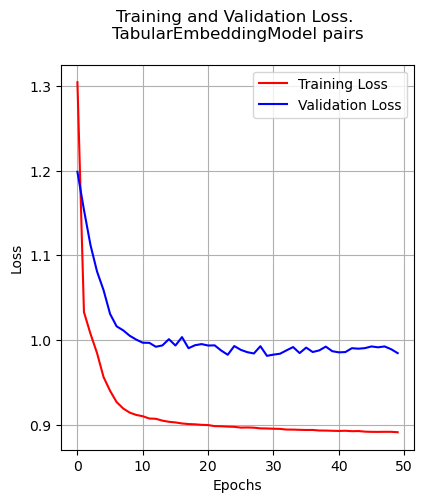

In [16]:
# first round of training
# cm = custom model
train_loss_list_cm_pairs,val_loss_list_cm_pairs =  snu.training_func(model_tab_custom_pairs, 
                                                   epochs, 
                                                   trainloader, 
                                                   valloader, 
                                                   lr=lr, 
                                                   l1_strength=l1_strength, 
                                                   l2_strength=l2_strength, 
                                                   optimizer=optimizer,
                                                   criterion=criterion, 
                                                   device=device, 
                                                   pairs=True, 
                                                   tabnet=False, 
                                                   best_valid_loss=np.inf,
                                                   train_loss_list=[], 
                                                   val_loss_list=[], 
                                                   save_res_to_file=True, 
                                                   plot_result = True)

In [37]:
# define the model
# Initialize the model
input_features = 90  
embedding_size = 16  
model_tab_custom_pairs = snu.TabularEmbeddingModel(input_features, embedding_size)
model_tab_custom_pairs.to(device)

TabularEmbeddingModel(
  (fc1): Linear(in_features=90, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=16, bias=True)
)

In [38]:
# parameters for training
lr = 0.001
l2_strength = 1e-07
l1_strength = 0
epochs = 50

# margin a little bit bigger that 2.415351 - median margin for dissimilar pairs
margin = 1.3

# Optimizer               
optimizer = optim.Adam(model_tab_custom_pairs.parameters(), lr=lr)


criterion = snu.ContrastiveLoss(margin=margin)

100%|██████████| 135/135 [00:07<00:00, 19.10it/s]


embedding_size: 16
lr: 0.001
l2_strength: 1e-07
l1_strength: 0



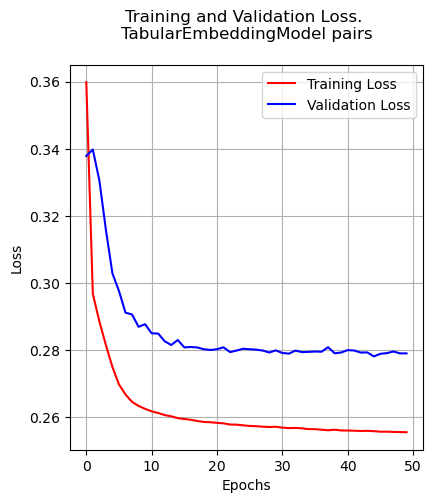

In [39]:
# first round of training
# cm = custom model
train_loss_list_cm_pairs,val_loss_list_cm_pairs =  snu.training_func(model_tab_custom_pairs, 
                                                   epochs, 
                                                   trainloader, 
                                                   valloader, 
                                                   lr=lr, 
                                                   l1_strength=l1_strength, 
                                                   l2_strength=l2_strength, 
                                                   optimizer=optimizer,
                                                   criterion=criterion, 
                                                   device=device, 
                                                   pairs=True, 
                                                   tabnet=False, 
                                                   best_valid_loss=np.inf,
                                                   train_loss_list=[], 
                                                   val_loss_list=[], 
                                                   save_res_to_file=True, 
                                                   plot_result = True)

<h3>Custom Tabular Model, pairs, CosineLoss</h3>

In [14]:
# define the model
# Initialize the model
input_features = 90  
embedding_size = 16  
model_tab_custom_pairs = snu.TabularEmbeddingModel(input_features, embedding_size)
model_tab_custom_pairs.to(device)

TabularEmbeddingModel(
  (fc1): Linear(in_features=90, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=16, bias=True)
)

In [38]:
model_tab_custom_pairs.to(device)

TabularEmbeddingModel(
  (fc1): Linear(in_features=90, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=16, bias=True)
)

In [39]:
# parameters for training
lr = 0.001
l2_strength = 1e-07
l1_strength = 0
epochs = 20

# margin 
margin = 0.5

# Optimizer               
optimizer = optim.Adam(model_tab_custom_pairs.parameters(), lr=lr)


criterion = snu.ContrastiveCosineLoss(margin=margin)

In [40]:
train_loss_list_cm_pairs,val_loss_list_cm_pairs = train_loss_list_cm_pairs.copy(),val_loss_list_cm_pairs.copy()

100%|██████████| 135/135 [00:06<00:00, 19.30it/s]


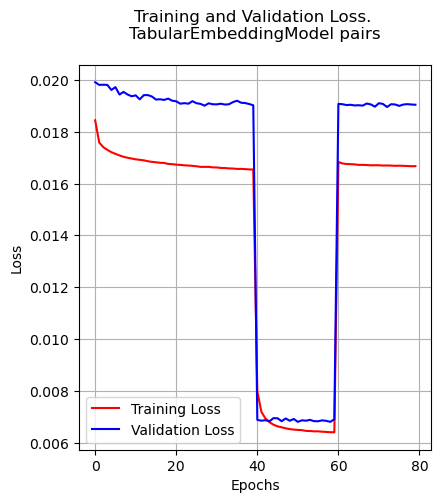

In [41]:
# first round of training
# cm = custom model
# 3rd round: smaller margin 0.3
train_loss_list_cm_pairs,val_loss_list_cm_pairs =  snu.training_func(model_tab_custom_pairs, 
                                                   epochs, 
                                                   trainloader, 
                                                   valloader, 
                                                   lr=lr, 
                                                   l1_strength=l1_strength, 
                                                   l2_strength=l2_strength, 
                                                   optimizer=optimizer,
                                                   criterion=criterion, 
                                                   device=device, 
                                                   pairs=True, 
                                                   tabnet=False, 
                                                   best_valid_loss=np.inf,
                                                   train_loss_list=train_loss_list_cm_pairs, 
                                                   val_loss_list=val_loss_list_cm_pairs, 
                                                   save_res_to_file=True, 
                                                   plot_result = True)

In [36]:
# # train set
# data_train_wo_emb = df_preprocessed[df_preprocessed['session_id'].isin(train_set_nn['session_id'])]

# #test set
# test_set_wo_emb = df_preprocessed[df_preprocessed['session_id'].isin(test_set_nn['session_id'])]

# # test set for umap
# ten_users = data_train_wo_emb['user_id'].sample(10)
# data_train_wo_emb_10 = data_train_wo_emb[data_train_wo_emb['user_id'].isin(ten_users)]

umap_hparams = {'n_neighbors':5,
                'min_dist':0.1,
                'n_components':2,
                'metric':'euclidean',
                'random_state': 42}

k = 1


100%|██████████| 70/70 [00:00<00:00, 4867.88it/s]


0.3142857142857143

k = 3


100%|██████████| 70/70 [00:00<00:00, 6133.43it/s]


0.4

k = 5


100%|██████████| 70/70 [00:00<00:00, 2339.25it/s]

0.4714285714285714




/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


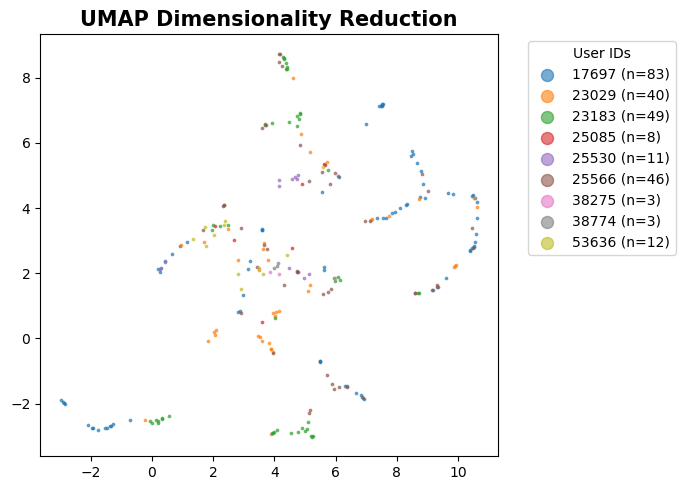

In [22]:
input_features = 90  
embedding_size = 16  
# model_tab_custom_pairs = snu.TabularEmbeddingModel(input_features, embedding_size)

# defive the model
model = model_tab_custom_pairs

# upload weights
# model.load_state_dict(torch.load('../models/best_models/best_TabularEmbeddingModel_pairs.pt'))
model.to('cpu')


index_wo_emb, user_ids_wo_emb = fuu.create_faiss_db(data_train_wo_emb, model)

k=1

for k in [1, 3, 5]:
    print("k =", k)
    faiss_search_res_cm_pairs = fuu.evaluate_faiss_db(k, 
                                                  test_set_wo_emb, 
                                                  index_wo_emb, 
                                                  user_ids_wo_emb, 
                                                  model=model)
    print()

fuu.umap_plot(data_train_wo_emb_10, umap_hparams, model=model, tabnet=False)

100%|██████████| 70/70 [00:00<00:00, 8165.80it/s]
/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


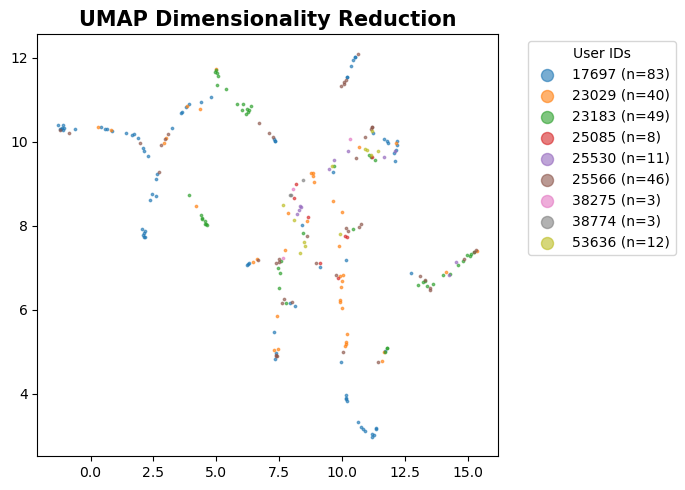

In [27]:
input_features = 90  
embedding_size = 16  
# model_tab_custom_pairs = snu.TabularEmbeddingModel(input_features, embedding_size)

# defive the model
model = model_tab_custom_pairs

# upload weights
# model.load_state_dict(torch.load('../models/best_models/best_TabularEmbeddingModel_pairs.pt'))
model.to('cpu')


index_wo_emb, user_ids_wo_emb = fuu.create_faiss_db(data_train_wo_emb, model)

k=1

for k in [1, 3, 5]:
    print("k =", k)
    faiss_search_res_cm_pairs = fuu.evaluate_faiss_db(k, 
                                                  test_set_wo_emb, 
                                                  index_wo_emb, 
                                                  user_ids_wo_emb, 
                                                  model=model)
    print()

fuu.umap_plot(data_train_wo_emb_10, umap_hparams, model=model, tabnet=False)

100%|██████████| 70/70 [00:00<00:00, 7631.95it/s]
/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


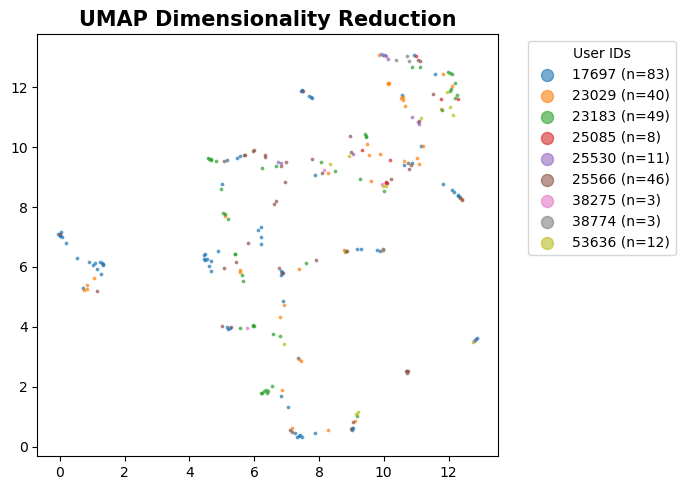

In [37]:
input_features = 90  
embedding_size = 16  
# model_tab_custom_pairs = snu.TabularEmbeddingModel(input_features, embedding_size)

# defive the model
model = model_tab_custom_pairs

# upload weights
# model.load_state_dict(torch.load('../models/best_models/best_TabularEmbeddingModel_pairs.pt'))
model.to('cpu')


index_wo_emb, user_ids_wo_emb = fuu.create_faiss_db(data_train_wo_emb, model)

k=1

for k in [1, 3, 5]:
    print("k =", k)
    faiss_search_res_cm_pairs = fuu.evaluate_faiss_db(k, 
                                                  test_set_wo_emb, 
                                                  index_wo_emb, 
                                                  user_ids_wo_emb, 
                                                  model=model)
    print()

fuu.umap_plot(data_train_wo_emb_10, umap_hparams, model=model, tabnet=False)

In [ ]:
input_features = 90  
embedding_size = 16  
# model_tab_custom_pairs = snu.TabularEmbeddingModel(input_features, embedding_size)

# defive the model
model = model_tab_custom_pairs

# upload weights
# model.load_state_dict(torch.load('../models/best_models/best_TabularEmbeddingModel_pairs.pt'))
model.to('cpu')


index_wo_emb, user_ids_wo_emb = fuu.create_faiss_db(data_train_wo_emb, model)

k=1

for k in [1, 3, 5]:
    print("k =", k)
    faiss_search_res_cm_pairs = fuu.evaluate_faiss_db(k, 
                                                  test_set_wo_emb, 
                                                  index_wo_emb, 
                                                  user_ids_wo_emb, 
                                                  model=model)
    print()

fuu.umap_plot(data_train_wo_emb_10, umap_hparams, model=model, tabnet=False)

<h3>TabNet Model, pairs</h3>

In [17]:
# define the model
# Initialize the model
input_features = 90  
embedding_size = 16  
model_tbnet_pairs = snu.TabNetEmbeddingModel(input_features, embedding_size)
model_tbnet_pairs.to(device)

# Ensure group attention matrix is also on GPU
if hasattr(model_tbnet_pairs.tabnet.encoder, 'group_attention_matrix'):
    model_tbnet_pairs.tabnet.encoder.group_attention_matrix = model_tbnet_pairs.tabnet.encoder.group_attention_matrix.to(device)

In [18]:
# parameters for training
lr = 0.001
l2_strength = 1e-05
l1_strength = 1e-07
epochs = 50

# margin a little bit bigger that 2.415351 - median margin for dissimilar pairs
margin = 2.43

# Optimizer               
optimizer = optim.Adam(model_tbnet_pairs.parameters(), lr=lr)


criterion = snu.ContrastiveLoss(margin=margin)

100%|██████████| 135/135 [00:10<00:00, 12.90it/s]


embedding_size: 16
lr: 0.001
l2_strength: 1e-05
l1_strength: 1e-07



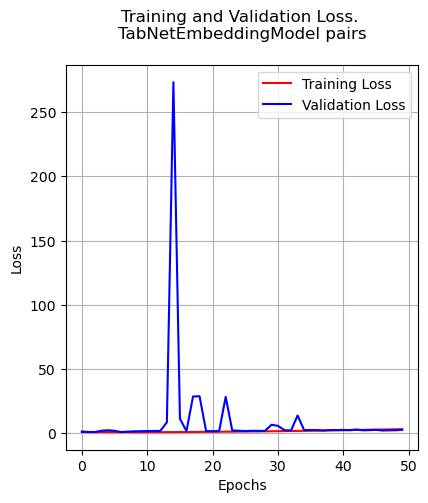

In [19]:
# first round of training
train_loss_list_tabnet_pairs,val_loss_list_tabnet_pairs =  snu.training_func(
                                                    model_tbnet_pairs, 
                                                   epochs, 
                                                   trainloader, 
                                                   valloader, 
                                                   lr=lr, 
                                                   l1_strength=l1_strength, 
                                                   l2_strength=l2_strength, 
                                                   optimizer=optimizer,
                                                   criterion=criterion, 
                                                   device=device, 
                                                   pairs=True, 
                                                   tabnet=True, 
                                                   best_valid_loss=np.inf,
                                                   train_loss_list=[], 
                                                   val_loss_list=[], 
                                                   save_res_to_file=True, 
                                                   plot_result = True)

In [28]:
# define the model
# Initialize the model
input_features = 90  
embedding_size = 16  
model_tbnet_pairs = snu.TabNetEmbeddingModel(input_features, embedding_size)
model_tbnet_pairs.to(device)

# Ensure group attention matrix is also on GPU
if hasattr(model_tbnet_pairs.tabnet.encoder, 'group_attention_matrix'):
    model_tbnet_pairs.tabnet.encoder.group_attention_matrix = model_tbnet_pairs.tabnet.encoder.group_attention_matrix.to(device)


In [29]:
# parameters for training
lr = 0.001
l2_strength = 1e-05
l1_strength = 1e-07
epochs = 50

# margin a little bit bigger that 2.415351 - median margin for dissimilar pairs
margin = 1.3

# Optimizer               
optimizer = optim.Adam(model_tbnet_pairs.parameters(), lr=lr)


criterion = snu.ContrastiveLoss(margin=margin)

100%|██████████| 135/135 [00:10<00:00, 12.84it/s]



embedding_size: 16
lr: 0.001
l2_strength: 1e-05
l1_strength: 1e-07



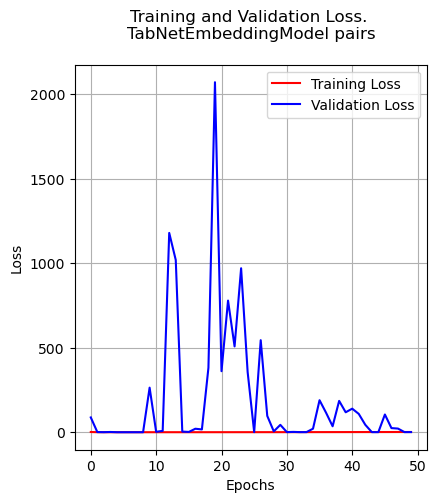

In [30]:
# first round of training
train_loss_list_tabnet_pairs,val_loss_list_tabnet_pairs =  snu.training_func(
                                                    model_tbnet_pairs, 
                                                   epochs, 
                                                   trainloader, 
                                                   valloader, 
                                                   lr=lr, 
                                                   l1_strength=l1_strength, 
                                                   l2_strength=l2_strength, 
                                                   optimizer=optimizer,
                                                   criterion=criterion, 
                                                   device=device, 
                                                   pairs=True, 
                                                   tabnet=True, 
                                                   best_valid_loss=np.inf,
                                                   train_loss_list=[], 
                                                   val_loss_list=[], 
                                                   save_res_to_file=True, 
                                                   plot_result = True)

<h3>Custom Tabular Model, triplets</h3>

In [20]:
# define the model
# Initialize the model
input_features = 90  
embedding_size = 16  
model_tab_custom_triplets = snu.TabularEmbeddingModel(input_features, embedding_size)
model_tab_custom_triplets.to(device)

TabularEmbeddingModel(
  (fc1): Linear(in_features=90, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=16, bias=True)
)

In [21]:
# parameters for training
lr = 0.001
l2_strength = 1e-05
l1_strength = 1e-07
epochs = 50

# margin a little bit bigger that 2.415351 - median margin for dissimilar pairs
margin = 2.43

# Optimizer               
optimizer = optim.Adam(model_tab_custom_triplets.parameters(), lr=lr)


criterion = nn.TripletMarginLoss(margin=margin)

100%|██████████| 23/23 [00:01<00:00, 13.70it/s]



embedding_size: 16
lr: 0.001
l2_strength: 1e-05
l1_strength: 1e-07



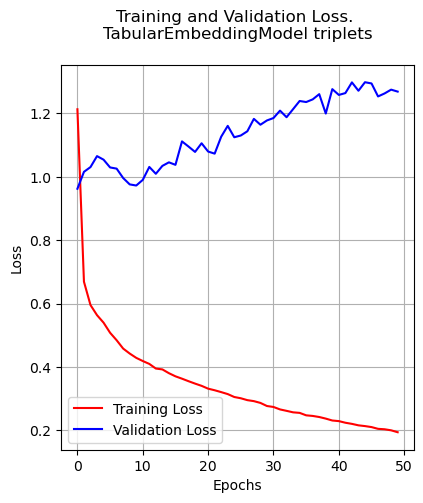

In [22]:
# first round of training
train_loss_list_cm_triplets,val_loss_list_cm_triplets =  snu.training_func(
                                                    model_tab_custom_triplets, 
                                                   epochs, 
                                                   trainloader_triplets, 
                                                   valloader_triplets, 
                                                   lr=lr, 
                                                   l1_strength=l1_strength, 
                                                   l2_strength=l2_strength, 
                                                   optimizer=optimizer,
                                                   criterion=criterion, 
                                                   device=device, 
                                                   pairs=False, 
                                                   tabnet=False, 
                                                   best_valid_loss=np.inf,
                                                   train_loss_list=[], 
                                                   val_loss_list=[], 
                                                   save_res_to_file=True, 
                                                   plot_result = True)

In [31]:
# define the model
# Initialize the model
input_features = 90  
embedding_size = 16  
model_tab_custom_triplets = snu.TabularEmbeddingModel(input_features, embedding_size)
model_tab_custom_triplets.to(device)

TabularEmbeddingModel(
  (fc1): Linear(in_features=90, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=16, bias=True)
)

In [32]:
# parameters for training
lr = 0.003
l2_strength = 1e-05
l1_strength = 1e-07
epochs = 50

# margin a little bit bigger that 2.415351 - median margin for dissimilar pairs
margin = 1.3

# Optimizer               
optimizer = optim.Adam(model_tab_custom_triplets.parameters(), lr=lr)


criterion = nn.TripletMarginLoss(margin=margin)

100%|██████████| 23/23 [00:01<00:00, 13.67it/s]



embedding_size: 16
lr: 0.003
l2_strength: 1e-05
l1_strength: 1e-07



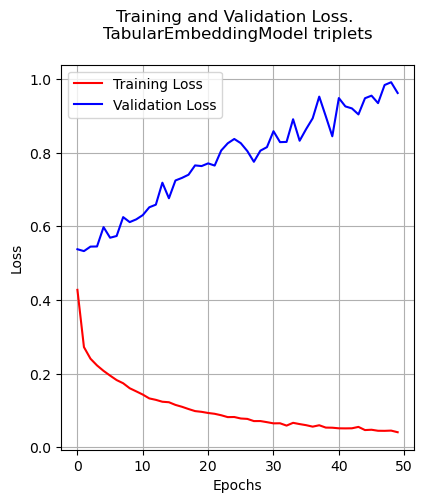

In [33]:
# first round of training
train_loss_list_cm_triplets,val_loss_list_cm_triplets =  snu.training_func(
                                                    model_tab_custom_triplets, 
                                                   epochs, 
                                                   trainloader_triplets, 
                                                   valloader_triplets, 
                                                   lr=lr, 
                                                   l1_strength=l1_strength, 
                                                   l2_strength=l2_strength, 
                                                   optimizer=optimizer,
                                                   criterion=criterion, 
                                                   device=device, 
                                                   pairs=False, 
                                                   tabnet=False, 
                                                   best_valid_loss=np.inf,
                                                   train_loss_list=[], 
                                                   val_loss_list=[], 
                                                   save_res_to_file=True, 
                                                   plot_result = True)

In [43]:
# define the model
# Initialize the model
input_features = 90  
embedding_size = 16  
model_tab_custom_triplets = snu.TabularEmbeddingModel(input_features, embedding_size)
model_tab_custom_triplets.to(device)

TabularEmbeddingModel(
  (fc1): Linear(in_features=90, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=16, bias=True)
)

In [44]:
# parameters for training
lr = 0.003
l2_strength = 1e-04
l1_strength = 1e-05
epochs = 50

# margin a little bit bigger that 2.415351 - median margin for dissimilar pairs
margin = 1.3

# Optimizer               
optimizer = optim.Adam(model_tab_custom_triplets.parameters(), lr=lr)


criterion = nn.TripletMarginLoss(margin=margin)

100%|██████████| 23/23 [00:01<00:00, 13.64it/s]



embedding_size: 16
lr: 0.003
l2_strength: 0.0001
l1_strength: 1e-05



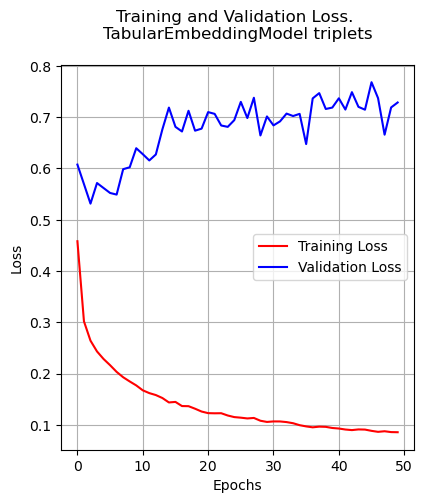

In [45]:
# first round of training
train_loss_list_cm_triplets,val_loss_list_cm_triplets =  snu.training_func(
                                                    model_tab_custom_triplets, 
                                                   epochs, 
                                                   trainloader_triplets, 
                                                   valloader_triplets, 
                                                   lr=lr, 
                                                   l1_strength=l1_strength, 
                                                   l2_strength=l2_strength, 
                                                   optimizer=optimizer,
                                                   criterion=criterion, 
                                                   device=device, 
                                                   pairs=False, 
                                                   tabnet=False, 
                                                   best_valid_loss=np.inf,
                                                   train_loss_list=[], 
                                                   val_loss_list=[], 
                                                   save_res_to_file=True, 
                                                   plot_result = True)

In [25]:
# define the model
# Initialize the model
input_features = 90  
embedding_size = 16  
model_tab_custom_triplets = snu.TabularEmbeddingModel(input_features, embedding_size)
model_tab_custom_triplets.to(device)

TabularEmbeddingModel(
  (fc1): Linear(in_features=90, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=16, bias=True)
)

In [26]:
# parameters for training
lr = 0.002
l2_strength = 1e-03
l1_strength = 1e-04
epochs = 15

# margin a little bit bigger that 2.415351 - median margin for dissimilar pairs
margin = 2.43

# Optimizer               
optimizer = optim.Adam(model_tab_custom_triplets.parameters(), lr=lr)


criterion = nn.TripletMarginLoss(margin=margin)

100%|██████████| 23/23 [00:01<00:00, 13.38it/s]


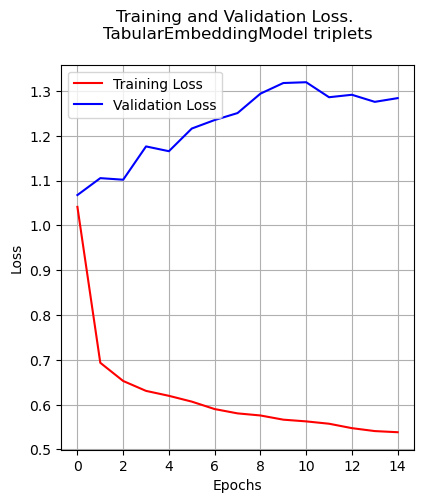

In [27]:
# first round of training
train_loss_list_cm_triplets,val_loss_list_cm_triplets =  snu.training_func(
                                                    model_tab_custom_triplets, 
                                                   epochs, 
                                                   trainloader_triplets, 
                                                   valloader_triplets, 
                                                   lr=lr, 
                                                   l1_strength=l1_strength, 
                                                   l2_strength=l2_strength, 
                                                   optimizer=optimizer,
                                                   criterion=criterion, 
                                                   device=device, 
                                                   pairs=False, 
                                                   tabnet=False, 
                                                   best_valid_loss=np.inf,
                                                   train_loss_list=[], 
                                                   val_loss_list=[], 
                                                   save_res_to_file=True, 
                                                   plot_result = True)

100%|██████████| 23/23 [00:01<00:00, 13.24it/s]


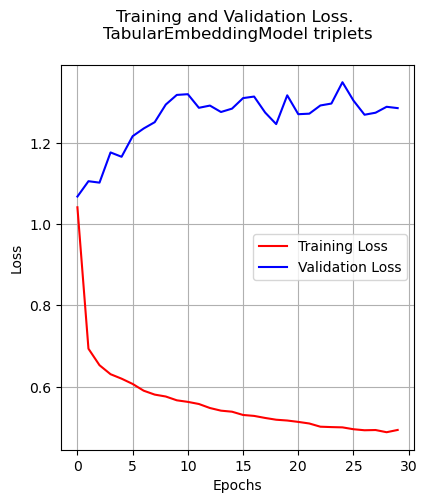

In [28]:
train_loss_list_cm_triplets,val_loss_list_cm_triplets =  snu.training_func(
                                                    model_tab_custom_triplets, 
                                                   epochs, 
                                                   trainloader_triplets, 
                                                   valloader_triplets, 
                                                   lr=lr, 
                                                   l1_strength=l1_strength, 
                                                   l2_strength=l2_strength, 
                                                   optimizer=optimizer,
                                                   criterion=criterion, 
                                                   device=device, 
                                                   pairs=False, 
                                                   tabnet=False, 
                                                   best_valid_loss=np.inf,
                                                   train_loss_list=train_loss_list_cm_triplets, 
                                                   val_loss_list=val_loss_list_cm_triplets, 
                                                   save_res_to_file=True, 
                                                   plot_result = True)

<h3>TabNet Model, triplets</h3>

In [23]:
# define the model
# Initialize the model
input_features = 90  
embedding_size = 16  
model_tab_tabnet_triplets = snu.TabNetEmbeddingModel(input_features, embedding_size)
model_tab_tabnet_triplets.to(device)

# Ensure group attention matrix is also on GPU
if hasattr(model_tab_tabnet_triplets.tabnet.encoder, 'group_attention_matrix'):
    model_tab_tabnet_triplets.tabnet.encoder.group_attention_matrix = model_tab_tabnet_triplets.tabnet.encoder.group_attention_matrix.to(device)

In [24]:
# parameters for training
lr = 0.001
l2_strength = 1e-05
l1_strength = 1e-07
epochs = 50

# margin a little bit bigger that 2.415351 - median margin for dissimilar pairs
margin = 2.43

# Optimizer               
optimizer = optim.Adam(model_tab_tabnet_triplets.parameters(), lr=lr)


criterion = nn.TripletMarginLoss(margin=margin)

100%|██████████| 23/23 [00:02<00:00,  9.24it/s]



embedding_size: 16
lr: 0.001
l2_strength: 1e-05
l1_strength: 1e-07



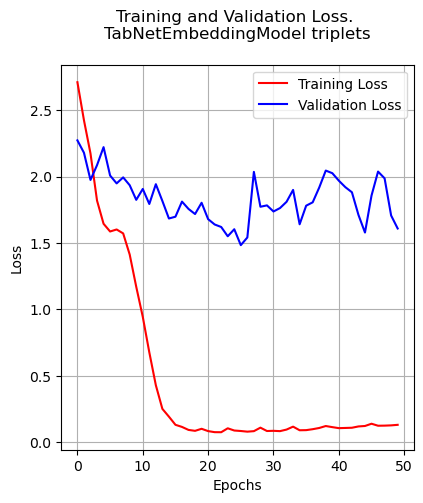

In [25]:
# first round of training
train_loss_list_tabnet_triplets,val_loss_list_tabnet_triplets =  snu.training_func(
                                                    model_tab_tabnet_triplets, 
                                                   epochs, 
                                                   trainloader_triplets, 
                                                   valloader_triplets, 
                                                   lr=lr, 
                                                   l1_strength=l1_strength, 
                                                   l2_strength=l2_strength, 
                                                   optimizer=optimizer,
                                                   criterion=criterion, 
                                                   device=device, 
                                                   pairs=False, 
                                                   tabnet=True, 
                                                   best_valid_loss=np.inf,
                                                   train_loss_list=[], 
                                                   val_loss_list=[], 
                                                   save_res_to_file=True, 
                                                   plot_result = True)

In [34]:
# define the model
# Initialize the model
input_features = 90  
embedding_size = 16  
model_tab_tabnet_triplets = snu.TabNetEmbeddingModel(input_features, embedding_size)
model_tab_tabnet_triplets.to(device)

# Ensure group attention matrix is also on GPU
if hasattr(model_tab_tabnet_triplets.tabnet.encoder, 'group_attention_matrix'):
    model_tab_tabnet_triplets.tabnet.encoder.group_attention_matrix = model_tab_tabnet_triplets.tabnet.encoder.group_attention_matrix.to(device)

In [35]:
# parameters for training
lr = 0.001
l2_strength = 1e-05
l1_strength = 1e-07
epochs = 50

# margin a little bit bigger that 2.415351 - median margin for dissimilar pairs
margin = 1.3

# Optimizer               
optimizer = optim.Adam(model_tab_tabnet_triplets.parameters(), lr=lr)


criterion = nn.TripletMarginLoss(margin=margin)

100%|██████████| 23/23 [00:02<00:00,  9.33it/s]



embedding_size: 16
lr: 0.001
l2_strength: 1e-05
l1_strength: 1e-07



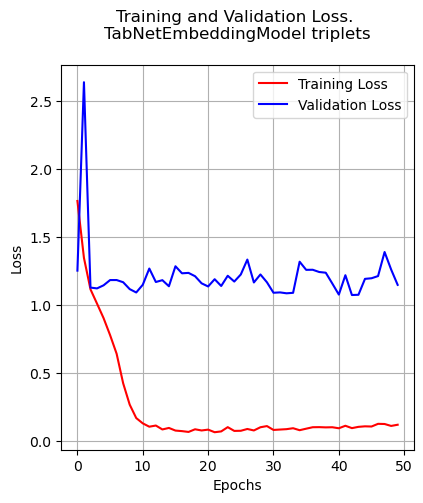

In [36]:
# first round of training
train_loss_list_tabnet_triplets,val_loss_list_tabnet_triplets =  snu.training_func(
                                                    model_tab_tabnet_triplets, 
                                                   epochs, 
                                                   trainloader_triplets, 
                                                   valloader_triplets, 
                                                   lr=lr, 
                                                   l1_strength=l1_strength, 
                                                   l2_strength=l2_strength, 
                                                   optimizer=optimizer,
                                                   criterion=criterion, 
                                                   device=device, 
                                                   pairs=False, 
                                                   tabnet=True, 
                                                   best_valid_loss=np.inf,
                                                   train_loss_list=[], 
                                                   val_loss_list=[], 
                                                   save_res_to_file=True, 
                                                   plot_result = True)

In [40]:
# define the model
# Initialize the model
input_features = 90  
embedding_size = 32
model_tab_tabnet_triplets = snu.TabNetEmbeddingModel(input_features, embedding_size)
model_tab_tabnet_triplets.to(device)

# Ensure group attention matrix is also on GPU
if hasattr(model_tab_tabnet_triplets.tabnet.encoder, 'group_attention_matrix'):
    model_tab_tabnet_triplets.tabnet.encoder.group_attention_matrix = model_tab_tabnet_triplets.tabnet.encoder.group_attention_matrix.to(device)

In [41]:
# parameters for training
lr = 0.001
l2_strength = 1e-05
l1_strength = 1e-07
epochs = 50

# margin a little bit bigger that 2.415351 - median margin for dissimilar pairs
margin = 1.3

# Optimizer               
optimizer = optim.Adam(model_tab_tabnet_triplets.parameters(), lr=lr)


criterion = nn.TripletMarginLoss(margin=margin)

100%|██████████| 23/23 [00:02<00:00,  9.26it/s]



embedding_size: 32
lr: 0.001
l2_strength: 1e-05
l1_strength: 1e-07



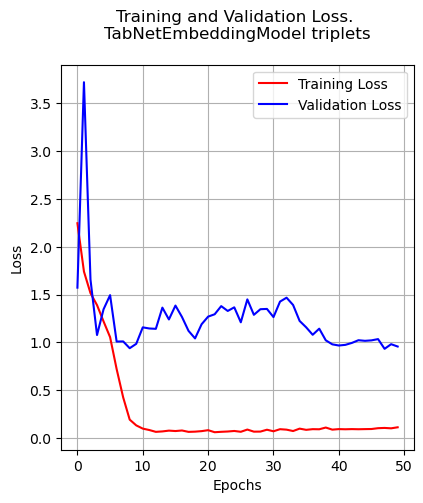

In [42]:
# first round of training
train_loss_list_tabnet_triplets,val_loss_list_tabnet_triplets =  snu.training_func(
                                                    model_tab_tabnet_triplets, 
                                                   epochs, 
                                                   trainloader_triplets, 
                                                   valloader_triplets, 
                                                   lr=lr, 
                                                   l1_strength=l1_strength, 
                                                   l2_strength=l2_strength, 
                                                   optimizer=optimizer,
                                                   criterion=criterion, 
                                                   device=device, 
                                                   pairs=False, 
                                                   tabnet=True, 
                                                   best_valid_loss=np.inf,
                                                   train_loss_list=[], 
                                                   val_loss_list=[], 
                                                   save_res_to_file=True, 
                                                   plot_result = True)

<h2>Test models</h2>

Further the test set consists from last sessions of each user in the train set

- create umap plot for 10 random users embedded by the given model

- to create index from train data embedded by the given model
- test on validation data
- test on random test data


Test cases:
- Raw data w/o embedding
- Custom Tabular Model with Contrastive Loss
- TabNet with Contrastive Loss
- Custom Tabular Model with TripletMargin Loss
- TabNet with TripletMargin Loss

In [9]:
# train set
data_train_wo_emb = df_preprocessed[df_preprocessed['session_id'].isin(train_set_nn['session_id'])]

#test set
test_set_wo_emb = df_preprocessed[df_preprocessed['session_id'].isin(test_set_nn['session_id'])]

# test set for umap
ten_users = data_train_wo_emb['user_id'].sample(10)
data_train_wo_emb_10 = data_train_wo_emb[data_train_wo_emb['user_id'].isin(ten_users)]

umap_hparams = {'n_neighbors':5,
                'min_dist':0.1,
                'n_components':2,
                'metric':'euclidean',
                'random_state': 42}

<h3>Preprocessed data w/o embedding</h3>

k = 1


100%|██████████| 70/70 [00:00<00:00, 5716.20it/s]


0.38571428571428573

k = 3


100%|██████████| 70/70 [00:00<00:00, 9123.15it/s]


0.4857142857142857

k = 5


100%|██████████| 70/70 [00:00<00:00, 9097.99it/s]

0.5285714285714286




/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


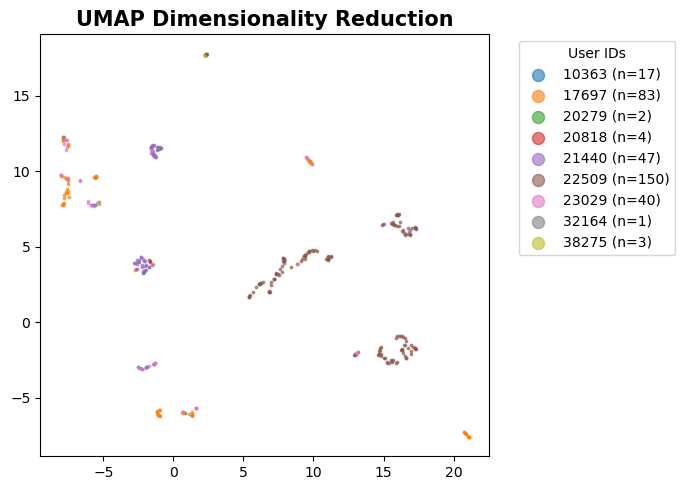

In [10]:
index_wo_emb, user_ids_wo_emb = fuu.create_faiss_db(data_train_wo_emb)


for k in [1, 3, 5]:
    print("k =", k)
    faiss_search_res_wo_emb = fuu.evaluate_faiss_db(k, 
                                                test_set_wo_emb, 
                                                index_wo_emb, 
                                                user_ids_wo_emb, 
                                                model=None)
    print()

fuu.umap_plot(data_train_wo_emb_10, umap_hparams, model=False, tabnet=False)

<h3>Embedded data with Tabular pairs model</h3>

k = 1


100%|██████████| 70/70 [00:00<00:00, 9144.18it/s]


0.3

k = 3


100%|██████████| 70/70 [00:00<00:00, 9421.17it/s]


0.37142857142857144

k = 5


100%|██████████| 70/70 [00:00<00:00, 8605.97it/s]

0.42857142857142855




/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


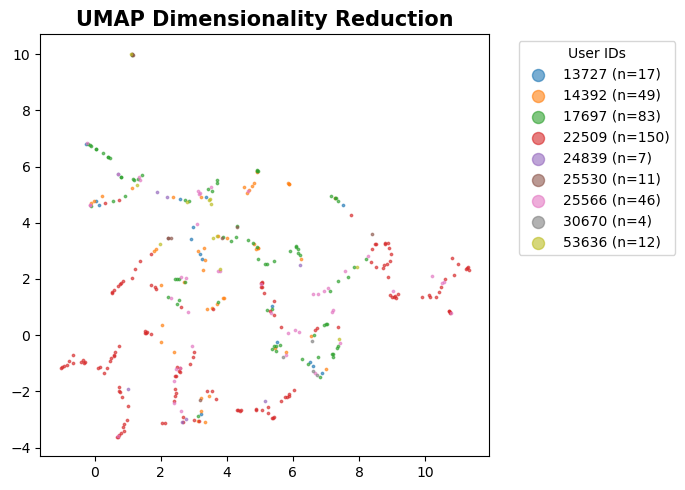

In [12]:
input_features = 90  
embedding_size = 16  
model_tab_custom_pairs = snu.TabularEmbeddingModel(input_features, embedding_size)

# defive the model
model = model_tab_custom_pairs

# upload weights
model.load_state_dict(torch.load('../models/best_models/best_TabularEmbeddingModel_pairs.pt'))
model.to('cpu')


index_wo_emb, user_ids_wo_emb = fuu.create_faiss_db(data_train_wo_emb, model)

k=1

for k in [1, 3, 5]:
    print("k =", k)
    faiss_search_res_cm_pairs = fuu.evaluate_faiss_db(k, 
                                                  test_set_wo_emb, 
                                                  index_wo_emb, 
                                                  user_ids_wo_emb, 
                                                  model=model)
    print()

fuu.umap_plot(data_train_wo_emb_10, umap_hparams, model=model, tabnet=False)

k = 1


  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [00:00<00:00, 745.88it/s]


0.2857142857142857

k = 3


100%|██████████| 70/70 [00:00<00:00, 2856.29it/s]


0.4142857142857143

k = 5


100%|██████████| 70/70 [00:00<00:00, 8398.45it/s]

0.45714285714285713




/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


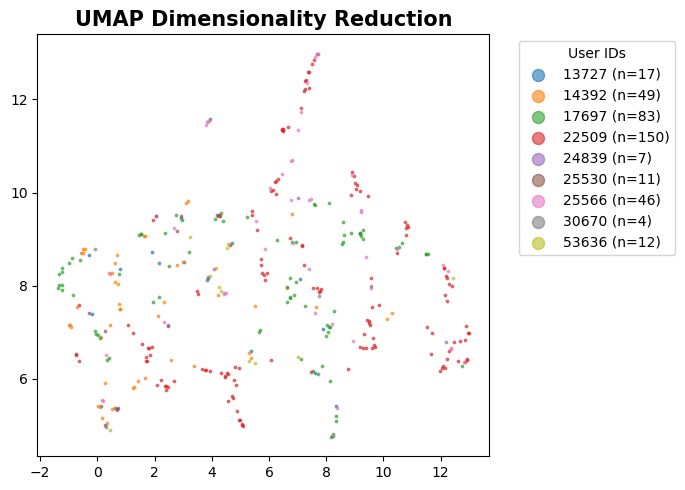

In [13]:
# input_features = 90  
# embedding_size = 16  
# model_tab_custom_pairs = snu.TabularEmbeddingModel(input_features, embedding_size)
model = model_tab_custom_pairs
model.load_state_dict(torch.load('../models/best_models/best_TabularEmbeddingModel_pairs_m243.pt'))
model.to('cpu')


index_wo_emb, user_ids_wo_emb = fuu.create_faiss_db(data_train_wo_emb, model)

k=1

for k in [1, 3, 5]:
    print("k =", k)
    faiss_search_res_cm_pairs = fuu.evaluate_faiss_db(k, 
                                                  test_set_wo_emb, 
                                                  index_wo_emb, 
                                                  user_ids_wo_emb, 
                                                  model=model)
    print()
    
fuu.umap_plot(data_train_wo_emb_10, umap_hparams, model=model, tabnet=False)

<h3>Embedded data with TabNet pairs model</h3>

k = 1


100%|██████████| 70/70 [00:00<00:00, 77.45it/s]


0.014285714285714285

k = 3


100%|██████████| 70/70 [00:01<00:00, 61.11it/s]


0.04285714285714286

k = 5


100%|██████████| 70/70 [00:01<00:00, 47.19it/s]
/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


0.05714285714285714



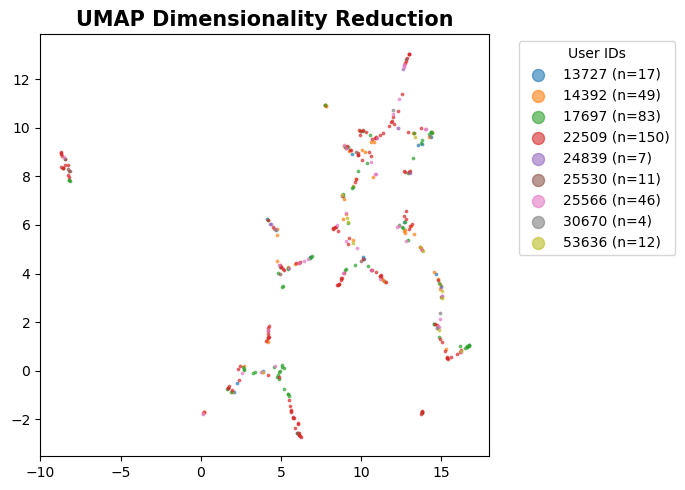

In [16]:
input_features = 90  
embedding_size = 16  
model_tbnet_pairs = snu.TabNetEmbeddingModel(input_features, embedding_size)

model = model_tbnet_pairs

model.load_state_dict(torch.load('../models/best_models/best_TabNetEmbeddingModel_pairs.pt'))
model.to('cpu')

# Ensure group attention matrix is also on GPU
if hasattr(model.tabnet.encoder, 'group_attention_matrix'):
    model.tabnet.encoder.group_attention_matrix = model.tabnet.encoder.group_attention_matrix.to('cpu')

index_wo_emb, user_ids_wo_emb = fuu.create_faiss_db(data_train_wo_emb, model, tabnet=True)

k=1

for k in [1, 3, 5]:
    print("k =", k)
    faiss_search_res_cm_pairs = fuu.evaluate_faiss_db(k, 
                                                  test_set_wo_emb, 
                                                  index_wo_emb, 
                                                  user_ids_wo_emb, 
                                                  model=model,
                                                  tabnet=True)
    print()


fuu.umap_plot(data_train_wo_emb_10, umap_hparams, model=model, tabnet=True)

<h3>Embedded data with Tabular triplets</h3>

k = 1


100%|██████████| 70/70 [00:00<00:00, 7126.76it/s]


0.4714285714285714

k = 3


  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [00:00<00:00, 6734.13it/s]


0.5571428571428572

k = 5


100%|██████████| 70/70 [00:00<00:00, 7166.08it/s]

0.6285714285714286




/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


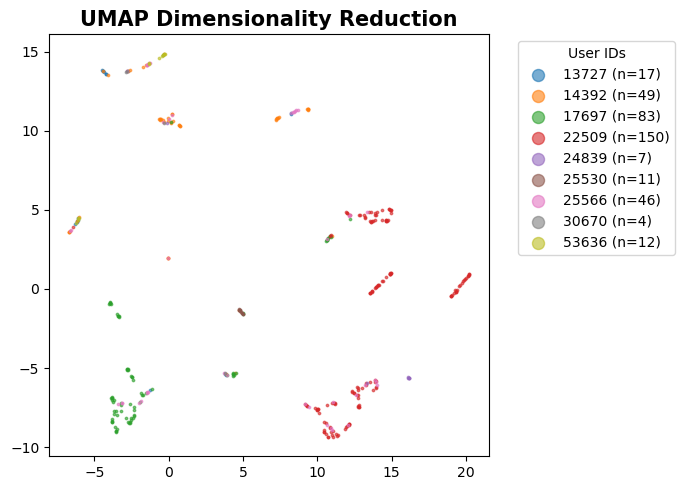

In [17]:
input_features = 90  
embedding_size = 16  
model_tab_custom_triplets = snu.TabularEmbeddingModel(input_features, embedding_size)

model = model_tab_custom_triplets
model.load_state_dict(torch.load('../models/best_models/best_TabularEmbeddingModel_triplets_1_m243.pt'))
model.to('cpu')

index_wo_emb, user_ids_wo_emb = fuu.create_faiss_db(data_train_wo_emb, model)

for k in [1, 3, 5]:
    print("k =", k)
    faiss_search_res_cm_pairs = fuu.evaluate_faiss_db(k, 
                                                  test_set_wo_emb, 
                                                  index_wo_emb, 
                                                  user_ids_wo_emb, 
                                                  model=model,
                                                  )
    print()

fuu.umap_plot(data_train_wo_emb_10, umap_hparams, model=model, tabnet=False)

k = 1


100%|██████████| 70/70 [00:00<00:00, 6343.88it/s]


0.44285714285714284

k = 3


100%|██████████| 70/70 [00:00<00:00, 1282.87it/s]


0.5285714285714286

k = 5


100%|██████████| 70/70 [00:00<00:00, 2130.65it/s]

0.5857142857142857




/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


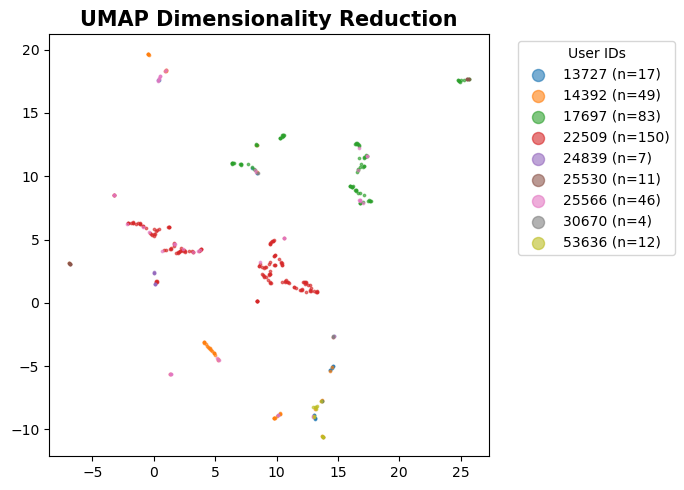

In [18]:
# input_features = 90  
# embedding_size = 16  
# model_tab_custom_pairs = snu.TabularEmbeddingModel(input_features, embedding_size)
model = model_tab_custom_triplets
model.load_state_dict(torch.load('../models/best_models/best_TabularEmbeddingModel_triplets_2_m13.pt'))
model.to('cpu')

index_wo_emb, user_ids_wo_emb = fuu.create_faiss_db(data_train_wo_emb, model)

for k in [1, 3, 5]:
    print("k =", k)
    faiss_search_res_cm_pairs = fuu.evaluate_faiss_db(k, 
                                                  test_set_wo_emb, 
                                                  index_wo_emb, 
                                                  user_ids_wo_emb, 
                                                  model=model,
                                                  )
    print()

fuu.umap_plot(data_train_wo_emb_10, umap_hparams, model=model, tabnet=False)

k = 1


  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [00:00<00:00, 798.40it/s]


0.4142857142857143

k = 3


100%|██████████| 70/70 [00:00<00:00, 2968.37it/s]


0.5

k = 5


100%|██████████| 70/70 [00:00<00:00, 8162.39it/s]

0.5857142857142857




/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


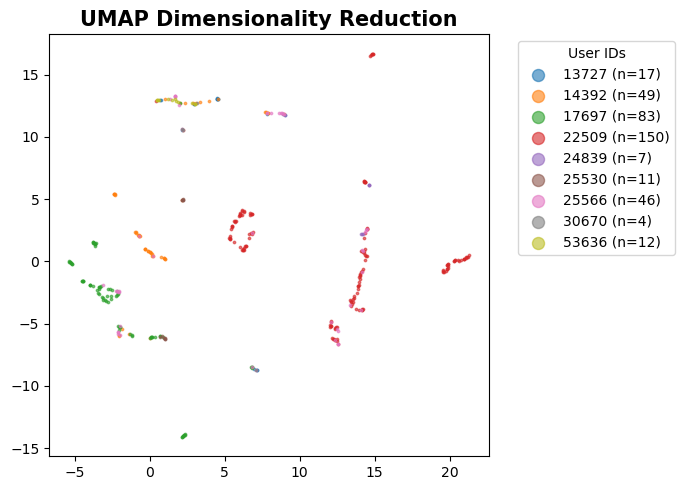

In [19]:
# input_features = 90  
# embedding_size = 16  
# model_tab_custom_pairs = snu.TabularEmbeddingModel(input_features, embedding_size)
model = model_tab_custom_triplets
model.load_state_dict(torch.load('../models/best_models/best_TabularEmbeddingModel_triplets.pt'))
model.to('cpu')

index_wo_emb, user_ids_wo_emb = fuu.create_faiss_db(data_train_wo_emb, model)

for k in [1, 3, 5]:
    print("k =", k)
    faiss_search_res_cm_pairs = fuu.evaluate_faiss_db(k, 
                                                  test_set_wo_emb, 
                                                  index_wo_emb, 
                                                  user_ids_wo_emb, 
                                                  model=model,
                                                  )
    print()

fuu.umap_plot(data_train_wo_emb_10, umap_hparams, model=model, tabnet=False)

k = 1


100%|██████████| 70/70 [00:00<00:00, 5715.65it/s]


0.5

k = 3


100%|██████████| 70/70 [00:00<00:00, 7012.71it/s]


0.5857142857142857

k = 5


100%|██████████| 70/70 [00:00<00:00, 6668.51it/s]

0.6




/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


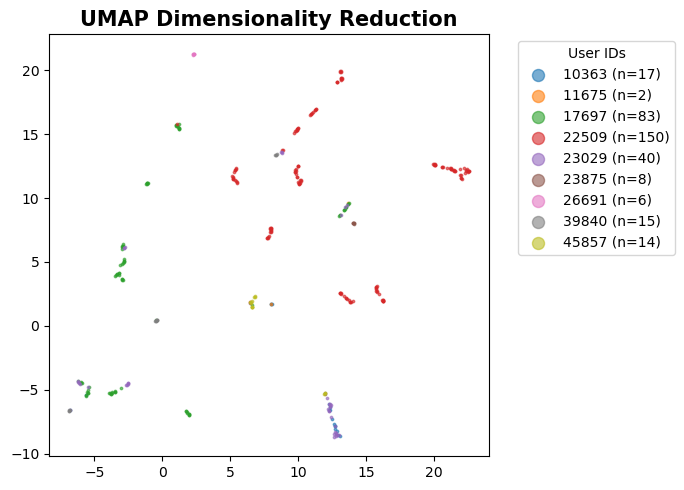

In [19]:
# trained with 10000 users
input_features = 90  
embedding_size = 16  
model_tab_custom_pairs = snu.TabularEmbeddingModel(input_features, embedding_size)
model = model_tab_custom_triplets
model.load_state_dict(torch.load('../models/best_models/best_TabularEmbeddingModel_triplets_4_10000users.pt'))
model.to('cpu')

index_wo_emb, user_ids_wo_emb = fuu.create_faiss_db(data_train_wo_emb, model)

for k in [1, 3, 5]:
    print("k =", k)
    faiss_search_res_cm_pairs = fuu.evaluate_faiss_db(k, 
                                                  test_set_wo_emb, 
                                                  index_wo_emb, 
                                                  user_ids_wo_emb, 
                                                  model=model,
                                                  )
    print()

fuu.umap_plot(data_train_wo_emb_10, umap_hparams, model=model, tabnet=False)

100%|██████████| 70/70 [00:00<00:00, 8374.25it/s]
/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


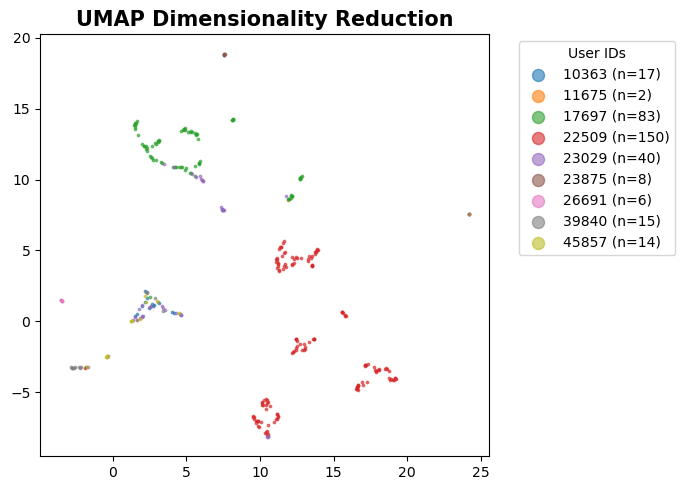

In [30]:
# 
input_features = 90  
embedding_size = 16  
model_tab_custom_pairs = snu.TabularEmbeddingModel(input_features, embedding_size)
model = model_tab_custom_triplets
model.load_state_dict(torch.load('../models/best_models/best_TabularEmbeddingModel_triplets.pt'))
model.to('cpu')

index_wo_emb, user_ids_wo_emb = fuu.create_faiss_db(data_train_wo_emb, model)

for k in [1, 3, 5]:
    print("k =", k)
    faiss_search_res_cm_pairs = fuu.evaluate_faiss_db(k, 
                                                  test_set_wo_emb, 
                                                  index_wo_emb, 
                                                  user_ids_wo_emb, 
                                                  model=model,
                                                  )
    print()

fuu.umap_plot(data_train_wo_emb_10, umap_hparams, model=model, tabnet=False)

<h3>Embedded data with TabNet triplets</h3>

k = 1


100%|██████████| 70/70 [00:01<00:00, 48.06it/s]


0.014285714285714285

k = 3


100%|██████████| 70/70 [00:01<00:00, 54.39it/s]


0.04285714285714286

k = 5


100%|██████████| 70/70 [00:01<00:00, 45.06it/s]
/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


0.07142857142857142



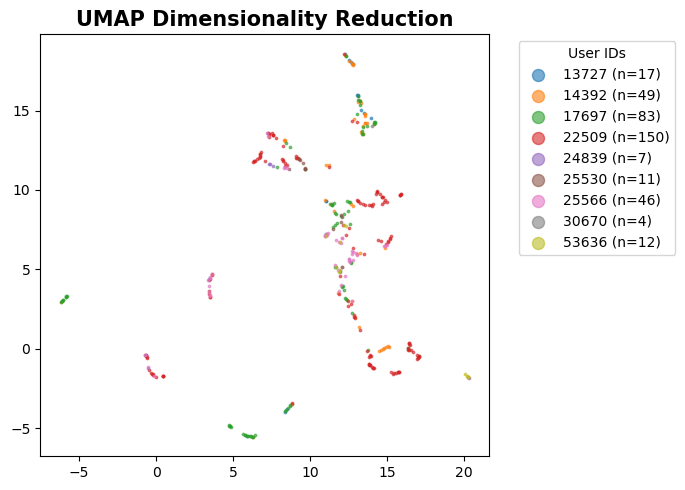

In [20]:
input_features = 90  
embedding_size = 16  
model_tab_tabnet_triplets = snu.TabNetEmbeddingModel(input_features, embedding_size)

model = model_tab_tabnet_triplets
model.load_state_dict(torch.load('../models/best_models/best_TabNetEmbeddingModel_triplets_1_m243.pt'))
model.to('cpu')

# Ensure group attention matrix is also on GPU
if hasattr(model.tabnet.encoder, 'group_attention_matrix'):
    model.tabnet.encoder.group_attention_matrix = model_tbnet_pairs.tabnet.encoder.group_attention_matrix.to('cpu')

index_wo_emb, user_ids_wo_emb = fuu.create_faiss_db(data_train_wo_emb, model, tabnet=True)

for k in [1, 3, 5]:
    print("k =", k)
    faiss_search_res_cm_pairs = fuu.evaluate_faiss_db(k, 
                                                  test_set_wo_emb, 
                                                  index_wo_emb, 
                                                  user_ids_wo_emb, 
                                                  model=model,
                                                  tabnet=True)
    print()


fuu.umap_plot(data_train_wo_emb_10, umap_hparams, model=model, tabnet=True)

k = 1


100%|██████████| 70/70 [00:01<00:00, 48.95it/s]


0.014285714285714285

k = 3


100%|██████████| 70/70 [00:01<00:00, 65.30it/s]


0.04285714285714286

k = 5


100%|██████████| 70/70 [00:00<00:00, 86.37it/s]
/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


0.07142857142857142



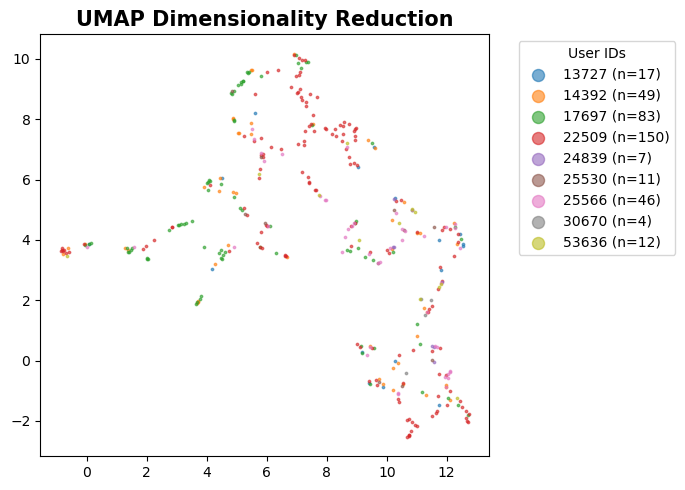

In [21]:
input_features = 90  
embedding_size = 16  
model_tab_tabnet_triplets = snu.TabNetEmbeddingModel(input_features, embedding_size)

model = model_tab_tabnet_triplets
model.load_state_dict(torch.load('../models/best_models/best_TabNetEmbeddingModel_triplets_2_m13.pt'))
model.to('cpu')

# Ensure group attention matrix is also on GPU
if hasattr(model.tabnet.encoder, 'group_attention_matrix'):
    model.tabnet.encoder.group_attention_matrix = model_tbnet_pairs.tabnet.encoder.group_attention_matrix.to('cpu')

index_wo_emb, user_ids_wo_emb = fuu.create_faiss_db(data_train_wo_emb, model, tabnet=True)

for k in [1, 3, 5]:
    print("k =", k)
    faiss_search_res_cm_pairs = fuu.evaluate_faiss_db(k, 
                                                  test_set_wo_emb, 
                                                  index_wo_emb, 
                                                  user_ids_wo_emb, 
                                                  model=model,
                                                  tabnet=True)
    print()

fuu.umap_plot(data_train_wo_emb_10, umap_hparams, model=model, tabnet=True)

k = 1


100%|██████████| 70/70 [00:00<00:00, 72.75it/s]


0.014285714285714285

k = 3


100%|██████████| 70/70 [00:01<00:00, 63.63it/s] 


0.02857142857142857

k = 5


100%|██████████| 70/70 [00:00<00:00, 71.96it/s]
/Users/evgenia_k/miniconda3/envs/kahoona_prj/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


0.04285714285714286



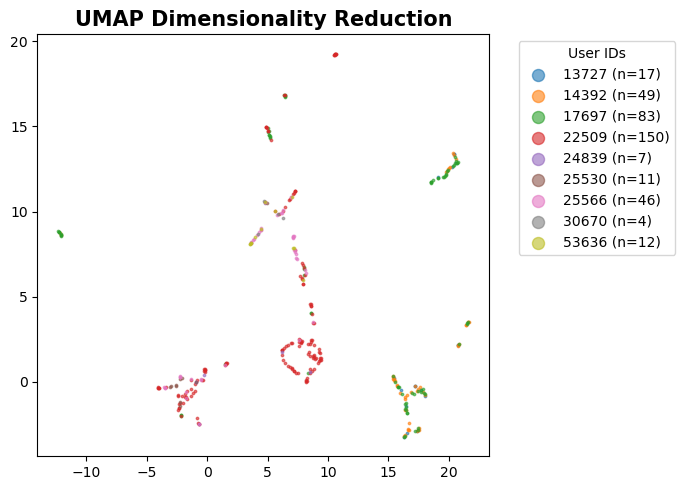

In [22]:
input_features = 90  
embedding_size = 32
model_tab_tabnet_triplets = snu.TabNetEmbeddingModel(input_features, embedding_size)

model = model_tab_tabnet_triplets
model.load_state_dict(torch.load('../models/best_models/best_TabNetEmbeddingModel_triplets_3_emb32.pt'))
model.to('cpu')

# Ensure group attention matrix is also on GPU
if hasattr(model.tabnet.encoder, 'group_attention_matrix'):
    model.tabnet.encoder.group_attention_matrix = model_tbnet_pairs.tabnet.encoder.group_attention_matrix.to('cpu')

index_wo_emb, user_ids_wo_emb = fuu.create_faiss_db(data_train_wo_emb, model, tabnet=True)

for k in [1, 3, 5]:
    print("k =", k)
    faiss_search_res_cm_pairs = fuu.evaluate_faiss_db(k, 
                                                  test_set_wo_emb, 
                                                  index_wo_emb, 
                                                  user_ids_wo_emb, 
                                                  model=model,
                                                  tabnet=True)
    print()

fuu.umap_plot(data_train_wo_emb_10, umap_hparams, model=model, tabnet=True)